# Steam Review Classification

INDEX:
- Problem Statement
- Dataset
- Exploratory Data Analysis
- Model selection
  - Standard Machine Learning Approach
  - LSTM + GloVe embeddings
  - Transformer Pretrained model
  - Fine Tune pretrained model

- Train best model on more Data
- Results
- Reference (bibliography)

## Problem Statement:
- The Dataset contain reviews about the games in the steam videogame platform with corresponding sentiment label (-1 = Negative, 1 = Positive)
- Type of problem: Text Classification: Sentiment Analysis

# Dataset
- The Steam Review Dataset is available on Kaggle  and is composed by 6+ milions rows and 5 columns where the Target Variable is: 'review_score’

 link: https://www.kaggle.com/datasets/andrewmvd/steam-reviews

# Dependencies

In [ ]:
!pip install WordCloud
!pip install emoji
!pip install transformers
!pip install tensorflow
!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 29.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import emoji
import itertools
import tensorflow as tf
import numpy as np

# preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from keras.preprocessing.text import Tokenizer
from imblearn.pipeline import Pipeline as ImbPipeline

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from transformers import BertTokenizer, TFBertForSequenceClassification, RobertaTokenizer, TFRobertaForSequenceClassification

# split
from sklearn.model_selection import train_test_split

#metrics
from sklearn.metrics import accuracy_score, classification_report, make_scorer, f1_score, roc_auc_score, roc_curve, precision_score, recall_score

# search
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from tensorflow.keras.layers import Bidirectional



In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# mount if needed
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


# Load Datasets
- put your specific path of the dataset




In [ ]:
# Take a sample of 100k rows of the steam Dataset (put your specific path of the dataset)
path_100k_sample = "df_sample_100k__dataset.csv"

In [ ]:
# look at some rows
df.head(10)

,app_id,app_name,review_text,review_score,review_votes
0,221100,DayZ,Early Access Review,1,0
1,322330,Don't Starve Together,Early Access Review,-1,1
2,272060,Serena,it has only one pop up scare,1,0
3,298160,Eldevin,"I Really Like The Game!!! Thumbs Up For Sure, ...",1,0
4,113400,APB Reloaded,I played this when it was in beta even though ...,1,0
5,8800,Sid Meier's Civilization IV: Beyond the Sword,My favourite game of all time...! The expansio...,1,0
6,433850,Z1 Battle Royale,Early Access Review,-1,0
7,289650,Assassin's Creed Unity,It is a big failure but i am still hoping that...,-1,0
8,238090,Sniper Elite 3,i want to back this game,1,1
9,223710,Cry of Fear,"♥♥♥♥ you ♥♥♥♥ing nigs go eat juice box cans, ♥...",1,0


# Exploratory Data Analysis

CONSIDERATION:
- Dataset contain:
   - imbalance classes => eventually handle using sampling strategy
   - duplicate review => delete them
   - null rows => delete them


In [ ]:
# check if the shape of the Dataset is as expected
df.shape

(82281, 2)

In [ ]:
# Shuffle the dataset
df = df.sample(frac=1, random_state=42)

In [ ]:

df.head()

,review_text,review_score
52206,"This game is awful, mechanics are super clunky...",-1
51552,Such a sweet game for those of you into the st...,1
53229,Half-life 2 is probably the best singleplayer ...,1
52099,I foam at the mouth and begin to blackout anyt...,1
69098,fun game to play. need to fix the team balanci...,1


In [ ]:
df.tail()

,review_text,review_score
7480,"Welp, this game is ummm lets see idk. GORY AF",1
66550,It may not be a surprise to most people that D...,1
93323,One of the best co op games i ever played! Th...,1
1026,This game has lasted a test of time over 15 ye...,1
19001,It's not what I expected and I am disappointed...,1


In [ ]:
# Maintain only the relevant colums (reviews and sentient)
df = df[['review_text', 'review_score']]

In [ ]:
# check for missing value
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   review_text   99867 non-null   object
 1   review_score  100000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.5+ MB


In [ ]:
# percentage missing values
df.isnull().sum(axis=0)/df.shape[0]

# Drop null rows
df.dropna(inplace = True)

In [ ]:
# check new shape
df.shape

(99867, 2)

In [ ]:
# eliminate duplicate reviews
df.drop_duplicates(inplace=True)

In [ ]:
df.shape

(82281, 2)

In [ ]:
# Visualize Some example of positive and negative review to understand better the data

# Separete positive and negative sentiment
positive_reviews = df[df['review_score'] == 1]
negative_reviews = df[df['review_score'] == -1]

# Select two random positive reviews
random_positive_reviews = positive_reviews.sample(n=2, random_state=42)

# Select two random negative reviews
random_negative_reviews = negative_reviews.sample(n=2, random_state=42)

print("Positive Review:", random_positive_reviews["review_text"])
print("------")
print("Negative Review:", random_negative_reviews["review_text"])

Positive Review: 33249    Smooth. Movement in this game felt much better...
8684     ONLY get the full edition, the normal game sucks.
Name: review_text, dtype: object
------
Negative Review: 30217    i7 Quad 4.2ghz CPU, GTX 980 &amp; running on a...
21483      A true masterpiece. This game truly sets the...
Name: review_text, dtype: object


- Check if dataset presents imbalance classes

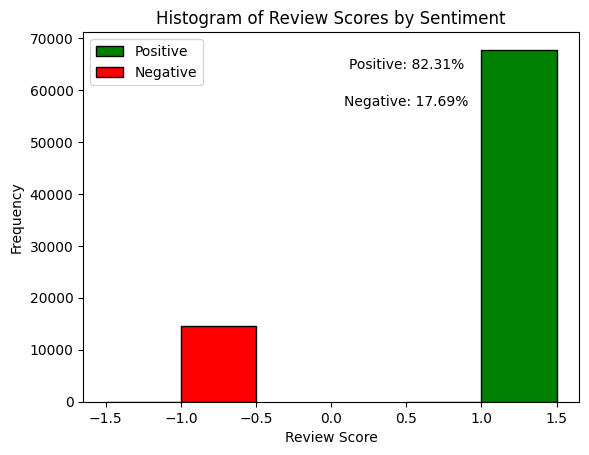

In [ ]:
# Check if dataset presents imbalance classes

# Visualize histograms for positive and negative sentiment
plt.hist(positive_reviews['review_score'], bins=2, edgecolor='black', color='green', label='Positive')
plt.hist(negative_reviews['review_score'], bins=2, edgecolor='black', color='red', label='Negative')

# title for the histogram
plt.xlabel('Review Score')
plt.ylabel('Frequency')
plt.title('Histogram of Review Scores by Sentiment')

# legend
plt.legend()

# percentage of positive and negative sentiment
total_count = len(df['review_score'])
positive_percentage = len(positive_reviews) / total_count * 100
negative_percentage = len(negative_reviews) / total_count * 100

# Add percentage text annotations to the plot
plt.text(0.5, max(plt.ylim()) * 0.9, f'Positive: {positive_percentage:.2f}%', ha='center')
plt.text(0.5, max(plt.ylim()) * 0.8, f'Negative: {negative_percentage:.2f}%', ha='center')

# Add a legend to differentiate positive and negative sentiment
plt.legend()

# Display the histogram
plt.show()

- WordCloud of Review

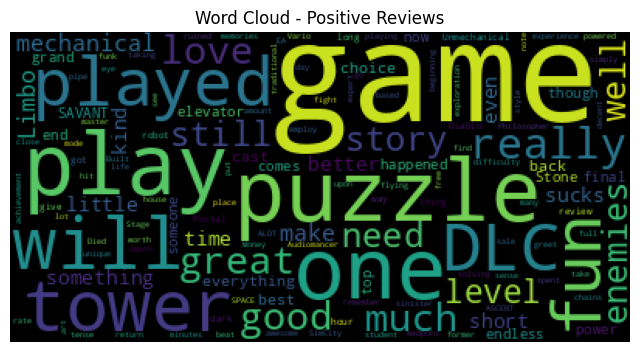

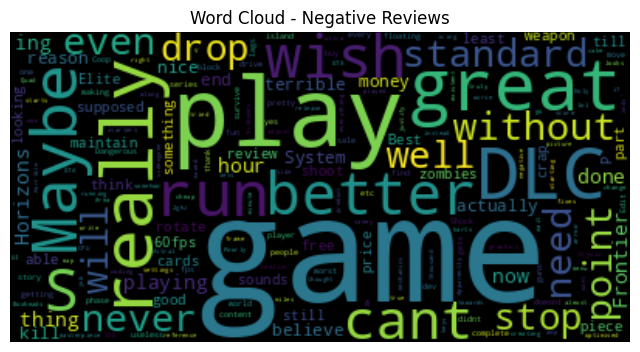

In [ ]:
# Reference: 1) (in section 'Reference')

# sample size
sample_size = 20

# Randomly select a sample of positive reviews
positive_reviews_sample =positive_reviews['review_text'].sample(n=sample_size, random_state=42)

# Randomly select a sample of negative reviews
negative_reviews_sample = negative_reviews['review_text'].sample(n=sample_size, random_state=42)

# word cloud for positive reviews sample
positive_wordcloud = WordCloud().generate(' '.join(positive_reviews_sample))

# word cloud for negative reviews sample
negative_wordcloud = WordCloud().generate(' '.join(negative_reviews_sample))

# Plot the positive word cloud
plt.figure(figsize=(8, 6))
plt.imshow(positive_wordcloud)
plt.title('Word Cloud - Positive Reviews')
plt.axis('off')
plt.show()

# Plot the negative word cloud
plt.figure(figsize=(8, 6))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('Word Cloud - Negative Reviews')
plt.axis('off')
plt.show()

In [ ]:
# Rename the columns to 'X' and 'y'
df = df.rename(columns={'review_text': 'X', 'review_score': 'y'})

# replace -1 with 0
df["y"] = df["y"].replace(-1, 0)

In [ ]:
df.head()

,X,y
52206,"This game is awful, mechanics are super clunky...",0
51552,Such a sweet game for those of you into the st...,1
53229,Half-life 2 is probably the best singleplayer ...,1
52099,I foam at the mouth and begin to blackout anyt...,1
69098,fun game to play. need to fix the team balanci...,1


# Text Preprocessing

CONSIDERATIONS:
- The harts emoji represent swear words
- I tried different approach for preprocessing (like non using stopwords,   encode differently emoji, use stem instead of lemmatizer etc) but more or less performance where similar (not in notebook aince lot of reduntant code)
- Using all stopwords might create problem on sentiment classification
  - Using no stopwords got bad result
  - Using a space ' ' instead of harts got bad results

PREPROCESSING STEPS:

  - Lowercase the text

  - replace the harts with "swear"
    
  - Remove special characters and punctuations

  - remove digits
   
  - remove multiple spaces
  
  - remove emoji

  - Remove some stopwords

  - Lemmatize the words

In [ ]:
heart_reviews = df[df['X'].str.contains('♥')].head(20)

# Display the 20 reviews that contain the heart emoji
for review in heart_reviews['X']:
    print(review)
    print('-----')


I Bought this game when it was on sale [5$] For me personaly i think it WAS DEFENETLY WORTH IT! :)  ♥♥♥♥ happens:   1. never Play with random people cuz they will crew ur stealth.... 2.Dont forget to put supressor when stealth. 3. Pls PLS PLS WORK DRILL PLS 10 more seconds... 2 seconds later Repair the Drill... 4. Pls HELP ME OUT [Nobody Helps u] 5. 10/10 Would repair the drill again and died cuz no help :D  For New Players:  -If u want to play with me Add me -If u need money add me -If u want to have fun add me - If u want to repair some more drills add me -And if u want to help me out ? Add me :D  Game? 10/10 I Recommend it  
-----
One of my favorite games. The difficulty/fun comes from the randomization aspect of it (items, rooms, drops, enemys, etc.), your skill, and your understanding of the various enemys / hazards and their behavior  Sometimes you become an overpowered abomination that can kill a boss within 0.5 seconds, other times you die because you are so underpowered it tak

In [ ]:
# Reference: 2)
# Filter the DataFrame to include rows with review texts containing emojis
emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)

emoji_reviews = df[df['X'].str.contains(emoji_pattern)]

In [ ]:
# Print 20 reviews containing emojis
emoji_samples = emoji_reviews['X'].head(20)

# Display the 30 examples of reviews with emojis
for review in emoji_samples:
    print(review)
    print('-----')

Get this game!!!👍
-----
Is pretty good 👍
-----
Love this game👍
-----
Classic 👌🏻 A True Tale From The Borderlands! 😉😉😉😂😂😂
-----
Just so cool , i love it 😻﻿ 💯/💯﻿ ^.^
-----
✋ ☹✋😐☜👎 ✌ ☹⚐❄ ❄☟✋💧 ☝✌💣☜ ☺🕆💧❄ ⚐☠☜ ⚐☞ ❄☟☜ 👌☜💧❄ ☝✌💣☜ ✋ ☜✞☜☼ 🏱☹✌✡☜👎 ✋ 👍✌☠❄ 👎☜💧👍☼✋👌☜ ❄☟✋💧   ✌🕈☜💧⚐💣☜ ✌🕈☜💧⚐💣☜✏  good luck to translate it!
-----
Love the co-op mode😆
-----
👌 
-----
Great game, great cars my only complain is the gearbox of the bmw m4 its doing Some crazy stuff 😂
-----
Great game and very addictive 👌👌
-----
🌟🌟🌟🌟🌟
-----
👌🏻
-----
One of the best open world zombie survival game. Really loved it. :) 😂🙌👍
-----
I love this game because way to give headshots better than cs go and sometimes players in the severs calling me hacker if they dead by me Imfaoo😉😘🇺🇿🙏🇺🇸
-----
You will get obsessed with this game an amazing game for all SCFI fans , a Thriller story takes place on planet Shear you play either as the monster or the hunters whom become the hunted later on in the game your objective as the monster is to eat eat and

In [ ]:
# Function that remove emoji, Reference: 2)
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [ ]:
# Understand the words that are in  stopwords
stop_words = set(stopwords.words('english'))
print(stop_words)

{'of', "didn't", 'y', 'he', 'mightn', "you're", 'isn', 'no', "mightn't", 'have', 'few', "won't", 'do', 'through', 's', "haven't", "weren't", 'while', 'off', 'why', 'wouldn', 'itself', 'this', 'if', "she's", "wasn't", 'is', "mustn't", 'will', 'she', 'did', 'by', 'that', 'for', 'there', 'be', 'his', 'ain', "hasn't", "hadn't", 'doing', 'during', 'just', "you've", 'them', 'don', 'some', 'over', 'in', 'the', 'ma', 'nor', 'out', "shouldn't", 'hadn', 'her', 'hers', 'were', "should've", 'didn', 'doesn', 'most', 'mustn', 'any', 'or', 'again', 'down', 'haven', 'what', 'to', "doesn't", 'shan', "that'll", 'our', 'they', 'll', 'was', 'myself', 'too', 'you', 'on', 'm', 'after', 'am', 'other', 'won', 'o', 'wasn', 'yourselves', 't', 'which', 'him', 'into', 'now', 'couldn', 'below', 'how', 'needn', 'at', 'd', 'can', 'more', 'who', 'under', 'their', 'been', 're', 'same', 'its', 'so', 'whom', 'up', "don't", "couldn't", "shan't", 'above', 'all', "needn't", 'being', 'when', 'both', 'very', 'but', 'a', 'my'

- text preprocessing function

In [ ]:
# preprocess text
def preprocess_text(text):

    # Lowercase the text
    text = text.lower()

    # replace the *** with swear
    text = re.sub(r"[♥]+", ' swear ' ,text)

    # Remove special characters and punctuations
    text = re.sub(r'[^\w\s]', '', text)

    #remove digits
    text = re.sub(r'\d+', ' ', text)

    #remove multiple spaces
    text = re.sub(r'\s+', ' ', text)

    #remove emoji
    text = remove_emoji(text)

    # Tokenize the text into words
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    # do not remove words 'not, no'
    stop_words -= {'not', 'no'}
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatize the words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Join the preprocessed tokens back into a single string
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text


In [ ]:
# Example of a review
example_review = "Even better than the first game. Better puzzles, great characters, expanded soundtrack. My only gripe is that there s a skateboarding mini-game during the class trials which makes absolutely no ♥♥♥♥ing sense, even in the what-the-♥♥♥♥ world of Danganronpa. 9/10, do not want to hang ten."

In [ ]:
#preprocess the review
example_review_pre = preprocess_text(example_review)

In [ ]:
# review after  the preprocessing
print("review after preprocessing: ", example_review_pre)

review after preprocessing:  even better first game better puzzle great character expanded soundtrack gripe skateboarding minigame class trial make absolutely no swear ing sense even whatthe swear world danganronpa not want hang ten


# Split into Training and Test set

CONSIDERATIONS:
- Use just a sample to find the best model, then train the best one on more data

In [ ]:
# take a sample of dataset to find best model
df_sample = df.sample(10000)

In [ ]:
# Apply preprocessing on the sample dataset
df_sample['X'] = df_sample['X'].apply(preprocess_text)

In [ ]:
df_sample.head(5)

,X,y
95678,awesome love game art style exceptional,1
894,picnic grassy hill tea biscuit pie played trai...,1
35477,imo best rpg last year,1
36584,really fun game,1
16353,love game fun everyone get game,1


In [ ]:
#SPLITS

# Split the dataset into X (features) and y (target)
X = df_sample['X']
y = df_sample['y']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# visualize dimension of sample split dataset
print(len(X_train), len(y_train))
print(len(X_test), len(y_test))

8000 8000
2000 2000


# MODEL SELECTION


TRY DIFFERENT APPROACHES:
 - Standard Machine Leanrning Algorithms
 - LSTM
 - Pretrained Transofmer
 - Fine Tune Transformer (take a lot of time)

# Machine Learning Approach:
- Use a TFIDFTokenizer and try different models:
  - Logistic Regression
  - RandomForest
  - XGBoost
  - SVM
- Use different configurations of hyperparameter and take in consideration the imbalnce classes


# Find Best TFIDFVectorizer dimension (max_feature)

CONSIDERATIONS:

As preprocessing for the ML algorithms i will use the tfidf Vectorizer, to understand what type of hyperparameter to use (max_features) I trained a Logistic Regression model using different values.
- Find the best hyperparameter for the tfidf Vectorizer (max_features)
  - There are 24k different words
  - checked without handling imbalance and got best parameter as : (max_features = 5000)
  - check using different sampling strategy to handle imbalance and got as best hyperparameter: (max_features = 20000), i will use this one

- Notice:
  - Using SMOTE, oversampling and Undersampling does not lead to better results, might consider to not use them later to speed up training
  - Even trying to hande imbalance we got modest results for the label 0 with respect to label 1

In [ ]:
# Find number of unique words (useful for TFIDFVectorizer later)
reviews = df_sample['X']

# Initialize the CountVectorizer
vectorizer = CountVectorizer()

# Fit and transform the review text
X = vectorizer.fit_transform(reviews)

# Get the unique words
vocabulary = vectorizer.get_feature_names_out()

# Count the number of unique words
num_unique_words = len(vocabulary)

print("Number of unique words in the review corpus:", num_unique_words)

Number of unique words in the review corpus: 24314


- Check best hyperparameter for TFIDF (without handling imabalance)

In [ ]:
# parameter grid
param_grid = {'vectorizer__max_features': [5000, 10000, 20000, 25000]}

# Initialize the TfidfVectorizer and LogisticRegression models
vectorizer = TfidfVectorizer()
model = LogisticRegression()

# pipeline with the vectorizer and model
pipeline = Pipeline([('vectorizer', vectorizer), ('model', model)])

# Random Search
search = RandomizedSearchCV(pipeline, param_grid, cv=5, n_iter=10)

# Fit the search object to the training data
search.fit(X_train, y_train)

# Get the best model and its hyperparameters
best_model = search.best_estimator_
best_params = search.best_params_

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print the best hyperparameters and evaluation metrics
print("Best Hyperparameters:", best_params)
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Classification Report:")
print(classification_rep)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Hyperparameters: {'vectorizer__max_features': 5000}
Accuracy: 0.861
F1 Score: 0.9211571185479296
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.28      0.41       347
           1       0.87      0.98      0.92      1653

    accuracy                           0.86      2000
   macro avg       0.82      0.63      0.67      2000
weighted avg       0.85      0.86      0.83      2000



- TRY MORE SAMPLING METHOD FOR THE MODEL


In [ ]:
# Define the parameter grid for random search
param_grid = {
    'vectorizer__max_features': [5000, 15000, 20000, 25000],
    'sampler': [SMOTE(), RandomUnderSampler()]
}

# Initialize the TfidfVectorizer and LogisticRegression models
vectorizer = TfidfVectorizer()
model = LogisticRegression()

# Create a pipeline with the vectorizer, sampler, and model
pipeline = ImbPipeline([
    ('vectorizer', vectorizer),
    ('sampler', SMOTE()),  # Default sampler for initial pipeline creation
    ('model', model)
])

# Perform random search with cross-validation
search = RandomizedSearchCV(pipeline, param_grid, cv=5, n_iter=20)

# Fit the search object to the training data
search.fit(X_train, y_train)

# Get the best model and its hyperparameters
best_model = search.best_estimator_
best_params = search.best_params_

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print the best hyperparameters and evaluation metrics
print("Best Hyperparameters:", best_params)
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Classification Report:")
print(classification_rep)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Hyperparameters: {'vectorizer__max_features': 20000, 'sampler': RandomUnderSampler()}
Accuracy: 0.787
F1 Score: 0.8599605522682446
Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.77      0.56       347
           1       0.94      0.79      0.86      1653

    accuracy                           0.79      2000
   macro avg       0.69      0.78      0.71      2000
weighted avg       0.85      0.79      0.81      2000



In [ ]:
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC AUC Score:", roc_auc)

ROC AUC Score: 0.7789295857152571


RESULTS:
- BEST HYPERPARAMETER FOR TFIDF = 20000


# Find best ML model (try different hyperparameter for each model)
Find the best ML model using different Algorithm and Sampling strategy

CONSIDERATIONS:
- All ML models got good results but there is margin for improvement for handle imbalance classes



- TRY TO HANDLE IMBALANCE WITH  SMOTE AND RANDOMUNDERSAMPLE

In [ ]:
# Define the classifier configurations
classifier_configs = [
    {
        'classifier': [LogisticRegression()],
        'classifier__max_iter': [100, 500, 1000],
        'sampler': [None, SMOTE(n_jobs=-1), RandomUnderSampler()]
    },
    {
        'classifier': [RandomForestClassifier(class_weight='balanced')],
        'classifier__n_estimators': [10, 100, 500],
        'classifier__max_depth': [None, 5, 10],
        'sampler': [None, SMOTE(n_jobs=-1), RandomUnderSampler()]
    },
    {
        'classifier': [XGBClassifier(objective='binary:logistic')],
        'classifier__max_depth': [3, 5, 7],
        'classifier__learning_rate': [0.1, 0.01, 0.001],
        'sampler': [None, SMOTE(n_jobs=-1), RandomUnderSampler()]
    },
    {
        'classifier': [SVC(probability=True)],
        'classifier__kernel': ['linear', 'rbf'],
        'classifier__C': [0.1, 1, 10],
        'sampler': [None, SMOTE(n_jobs=-1), RandomUnderSampler()]
    }
]

# model names
model_names = ['Logistic Regression', 'Random Forest', 'XGBoost', 'SVM']

# parameter grid for random search
all_configs = [dict(itertools.chain(*(e.items() for e in configuration))) for configuration in itertools.product(classifier_configs)]

# pipeline with TfidfVectorizer, sampler, and classifier
# pipeline = Pipeline([
#     ('vectorizer', TfidfVectorizer(max_features=20000)),
#     ('sampler', None),
#     ('classifier', LogisticRegression())
# ])

pipeline = ImbPipeline([
    ('vectorizer', TfidfVectorizer(max_features=20000)),
    ('sampler', None),
    ('classifier', LogisticRegression())
])


# random search with cross-validation
rs = RandomizedSearchCV(pipeline,
                        param_distributions=all_configs,
                        n_iter=len(all_configs) * 10,
                        n_jobs=-1,
                        cv=2,
                        scoring={
                            'accuracy': make_scorer(accuracy_score),
                            'f1': make_scorer(f1_score)
                        },
                        refit='f1'
                        )

# cross-validation with scoring
scores = cross_validate(rs, X_train, y_train, scoring=['accuracy', 'f1'], cv=4, return_estimator=True, verbose=3, error_score='raise')

for i, (model_name, estimator) in enumerate(zip(model_names, scores['estimator'])):
    print(f"Model: {model_name} Accuracy: {estimator.cv_results_['mean_test_accuracy'][estimator.best_index_]}")
    print(f"Model: {model_name} F1 Score: {estimator.cv_results_['mean_test_f1'][estimator.best_index_]}")

    # Fit the best estimator on the training data
    best_estimator = estimator.best_estimator_
    best_estimator.fit(X_train, y_train)

    # Predict on the test data
    y_pred = best_estimator.predict(X_test)

    # Calculate precision and recall
    report = classification_report(y_test, y_pred)
    print(f"\nClassification Report:\n{report}\n")


[CV] END ............ accuracy: (test=0.865) f1: (test=0.922) total time= 9.8min
[CV] END ............ accuracy: (test=0.877) f1: (test=0.929) total time= 8.0min
[CV] END ............ accuracy: (test=0.872) f1: (test=0.926) total time= 8.7min
[CV] END ............ accuracy: (test=0.875) f1: (test=0.928) total time= 8.0min
Model: Logistic Regression Accuracy: 0.8674999999999999
Model: Logistic Regression F1 Score: 0.9240616876137546

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.44      0.56       347
           1       0.89      0.97      0.93      1653

    accuracy                           0.88      2000
   macro avg       0.82      0.71      0.74      2000
weighted avg       0.87      0.88      0.86      2000


Model: Random Forest Accuracy: 0.8646666666666667
Model: Random Forest F1 Score: 0.9225140411898218

Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.44

In [ ]:
# Get the best hyperparameters of the best models
best_hyperparameters = []
for i, (model_name, estimator) in enumerate(zip(model_names, scores['estimator'])):
    best_params = estimator.best_params_
    best_hyperparameters.append((model_name, best_params))

# Print the best hyperparameters of the best models
for model_name, best_params in best_hyperparameters:
    print(f"Model: {model_name}")
    print("Best Hyperparameters:")
    for param, value in best_params.items():
        print(f"{param}: {value}")
    print()


Model: Logistic Regression
Best Hyperparameters:
sampler: None
classifier__kernel: linear
classifier__C: 1
classifier: SVC(C=1, kernel='linear', probability=True)

Model: Random Forest
Best Hyperparameters:
sampler: None
classifier__kernel: linear
classifier__C: 1
classifier: SVC(C=1, kernel='linear', probability=True)

Model: XGBoost
Best Hyperparameters:
sampler: None
classifier__kernel: rbf
classifier__C: 10
classifier: SVC(C=10, probability=True)

Model: SVM
Best Hyperparameters:
sampler: None
classifier__kernel: linear
classifier__C: 1
classifier: SVC(C=1, kernel='linear', probability=True)



# Depp Learning and LSTM with GloVe Embeddings


Steps:
- Load GloVe pretrained embeddings
- Train and Evaluate a LSTM model
- Try to Handle imbalance classes



In [ ]:
# Reference:3

# Tokenize the text and convert to sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [ ]:
# find maximum length of a review
max_len = max(len(seq) for seq in X_train_seq)
max_len

724

In [ ]:
# Pad sequences to have equal length
X_train_padded = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

In [ ]:
# Find number of unique words
word_index = tokenizer.word_index
print("Number of uniqe words:", len(word_index))

Number of uniqe words: 21227


In [ ]:
# Just to ensure that the labels and data are correctly formatted.
print(X_train[:5], y_train[:5])
print(X_test[:5], y_test[:5])


25016    went game thinking would something like island...
9292                      lol terrarium ftw minecraft suck
49369                                         ok kind game
3760                                   father father proof
13067    generic amp auto fail stealth mission absolutl...
Name: X, dtype: object 25016    1
9292     1
49369    1
3760     1
13067    0
Name: y, dtype: int64
18381    gtme running finger throttle trigger repeatede...
50110    enjoy bring getting low swear well monster kil...
76133    game far longer ive steam always found fun sta...
12954    game lot bug right developer still working bug...
87343                      jaw dropped right opening scene
Name: X, dtype: object 18381    1
50110    1
76133    1
12954    1
87343    1
Name: y, dtype: int64


- Below in "glove_f" put your path of the glove embeddings

In [ ]:
#Reference: 3)

#Initializing GloVe word embedding
from numpy import asarray

# Load the file with pretrained embeddings
embeddings_index = dict()
glove_f = open('glove.6B.100d.txt', encoding='utf-8')
for line in glove_f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
glove_f.close()

print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 216212 word vectors.


In [ ]:
# Create embedding matrix
word_index = tokenizer.word_index
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
# SMOTE to handle class imbalance
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_padded, y_train)

# Model definition
model = Sequential()
model.add(Embedding(num_words, embed_dim, weights=[embedding_matrix], input_length=max_len, trainable=False))
model.add(Bidirectional(LSTM(128, return_sequences=True, dropout=0.2)))
model.add(Dropout(0.5))  # Added dropout layer
model.add(Bidirectional(LSTM(64, dropout=0.2)))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))  # Added dropout layer
model.add(Dense(1, activation='sigmoid'))

# Optimizer
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])

# Early stopping
early_stopping = EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True)

# Model training
history = model.fit(
    X_train_res, y_train_res,
    validation_data=(X_test_padded, y_test),
    epochs=70, batch_size=64,
    # callbacks=[early_stopping]
)

# Model evaluation
loss, auc = model.evaluate(X_test_padded, y_test)

# Predictions
y_pred = model.predict(X_test_padded)
y_pred = y_pred.round().astype("float")

# Metrics calculation
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
classification_rep = classification_report(y_test, y_pred)

# Results printing
print(f"AUC: {auc}")
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"Classification Report:\n{classification_rep}")


Epoch 1/70
207/207 [==============================] - 34s 127ms/step - loss: 0.5800 - auc_5: 0.7651 - val_loss: 0.6214 - val_auc_5: 0.6864
Epoch 2/70
207/207 [==============================] - 26s 126ms/step - loss: 0.5217 - auc_5: 0.8209 - val_loss: 0.5486 - val_auc_5: 0.7125
Epoch 3/70
207/207 [==============================] - 26s 125ms/step - loss: 0.4783 - auc_5: 0.8529 - val_loss: 0.7205 - val_auc_5: 0.7397
Epoch 4/70
207/207 [==============================] - 25s 123ms/step - loss: 0.4471 - auc_5: 0.8741 - val_loss: 0.5499 - val_auc_5: 0.7372
Epoch 5/70
207/207 [==============================] - 27s 130ms/step - loss: 0.4338 - auc_5: 0.8819 - val_loss: 0.4891 - val_auc_5: 0.7415
Epoch 6/70
207/207 [==============================] - 26s 125ms/step - loss: 0.3989 - auc_5: 0.9012 - val_loss: 0.5539 - val_auc_5: 0.7712
Epoch 7/70
207/207 [==============================] - 26s 125ms/step - loss: 0.3718 - auc_5: 0.9151 - val_loss: 0.4684 - val_auc_5: 0.7788
Epoch 8/70
207/207 [=======

In [ ]:
# save model (if needed)
model.save('lstm_model_2.h5')

# Transformers and Pretrained Models

- First use some pretrained models directly to predict sentiment then use the best one for Fine Tuning

# Try pretrained model directly without training on our data
- Use models RoBERTa and BERT




# ROBERTA

In [ ]:
# RoBERTa, Reference: 4)

# Initialize the tokenizer
roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

# Tokenize the input texts
X_train_roberta = roberta_tokenizer.batch_encode_plus(X_train.tolist(), padding=True, truncation=True, return_tensors='tf')
X_test_roberta = roberta_tokenizer.batch_encode_plus(X_test.tolist(), padding=True, truncation=True, return_tensors='tf')

# Create TensorFlow datasets
train_dataset_roberta = tf.data.Dataset.from_tensor_slices((
    dict(X_train_roberta),
    y_train
)).batch(32)

test_dataset_roberta = tf.data.Dataset.from_tensor_slices((
    dict(X_test_roberta),
    y_test
)).batch(32)

# Load the pre-trained RoBERTa model
roberta_model = TFRobertaForSequenceClassification.from_pretrained('roberta-base')

# Compile the model
roberta_model.compile(optimizer='adam',
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])

# Evaluate the model
predictions_roberta = roberta_model.predict(test_dataset_roberta)
predicted_labels_roberta = tf.argmax(predictions_roberta.logits, axis=1)
accuracy_roberta = accuracy_score(y_test, predicted_labels_roberta)
f1_roberta = f1_score(y_test, predicted_labels_roberta)
precision_roberta = precision_score(y_test, predicted_labels_roberta)
recall_roberta = recall_score(y_test, predicted_labels_roberta)

print('RoBERTa Model')
print('Test Accuracy:', accuracy_roberta)
print('F1 Score:', f1_roberta)
print('Precision:', precision_roberta)
print('Recall:', recall_roberta)
print()


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

63/63 [==============================] - 80s 1s/step
RoBERTa Model
Test Accuracy: 0.1765
F1 Score: 0.0
Precision: 0.0
Recall: 0.0



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Evaluate the model with classification report
predictions_roberta = roberta_model.predict(test_dataset_roberta)
predicted_labels_roberta = tf.argmax(predictions_roberta.logits, axis=1)

classification_report_roberta = classification_report(y_test, predicted_labels_roberta, target_names=["Negative", "Positive"])
print('RoBERTa Model')
print(classification_report_roberta)

63/63 [==============================] - 75s 1s/step
RoBERTa Model
              precision    recall  f1-score   support

    Negative       0.18      1.00      0.30       353
    Positive       0.00      0.00      0.00      1647

    accuracy                           0.18      2000
   macro avg       0.09      0.50      0.15      2000
weighted avg       0.03      0.18      0.05      2000



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# BERT

In [ ]:
# REFERENCE: 4)

# Initialize the tokenizer
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the input texts
X_train_bert = bert_tokenizer.batch_encode_plus(X_train.tolist(), padding=True, truncation=True, return_tensors='tf')
X_test_bert = bert_tokenizer.batch_encode_plus(X_test.tolist(), padding=True, truncation=True, return_tensors='tf')

# Create TensorFlow datasets
train_dataset_bert = tf.data.Dataset.from_tensor_slices((
    dict(X_train_bert),
    y_train
)).batch(32)

test_dataset_bert = tf.data.Dataset.from_tensor_slices((
    dict(X_test_bert),
    y_test
)).batch(32)

# Load the pre-trained BERT model
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased')

# Compile the model
bert_model.compile(optimizer='adam',
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy'])

# Evaluate the model
predictions_bert = bert_model.predict(test_dataset_bert)
predicted_labels_bert = tf.argmax(predictions_bert.logits, axis=1)
accuracy_bert = accuracy_score(y_test, predicted_labels_bert)
f1_bert = f1_score(y_test, predicted_labels_bert)
precision_bert = precision_score(y_test, predicted_labels_bert)
recall_bert = recall_score(y_test, predicted_labels_bert)

print('BERT Model')
print('Test Accuracy:', accuracy_bert)
print('F1 Score:', f1_bert)
print('Precision:', precision_bert)
print('Recall:', recall_bert)
print()

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


63/63 [==============================] - 80s 1s/step
BERT Model
Test Accuracy: 0.8195
F1 Score: 0.9005783530707795
Precision: 0.8312150482968989
Recall: 0.9825721153846154



In [ ]:
# Evaluate the model
predictions_bert = bert_model.predict(test_dataset_bert)
predicted_labels_bert = tf.argmax(predictions_bert.logits, axis=1)

classification_report_bert = classification_report(y_test, predicted_labels_bert, target_names=["Negative", "Positive"])
print('BERT Model')
print(classification_report_bert)


63/63 [==============================] - 76s 1s/step
BERT Model
              precision    recall  f1-score   support

    Negative       0.12      0.01      0.02       336
    Positive       0.83      0.98      0.90      1664

    accuracy                           0.82      2000
   macro avg       0.48      0.50      0.46      2000
weighted avg       0.71      0.82      0.75      2000



- Try to change threshold for prediction
  - still poor results

In [ ]:
# Try to change threshold for prediction (still got poor results)

# Set the threshold for label 0
threshold = 0.66

# Get predicted probabilities for each class
predicted_probabilities_bert = tf.nn.softmax(predictions_bert.logits, axis=1)
predicted_labels_bert = tf.cast(predicted_probabilities_bert[:, 1] > threshold, tf.int32)

# Calculate metrics
accuracy_bert = accuracy_score(y_test, predicted_labels_bert)
f1_bert = f1_score(y_test, predicted_labels_bert)
precision_bert = precision_score(y_test, predicted_labels_bert)
recall_bert = recall_score(y_test, predicted_labels_bert)

print('BERT Model with Modified Threshold')
print('Test Accuracy:', accuracy_bert)
print('F1 Score:', f1_bert)
print('Precision:', precision_bert)
print('Recall:', recall_bert)

# Calculate classification report
report = classification_report(y_test, predicted_labels_bert)
print(f"Classification Report for BERT Model with Modified Threshold:\n{report}\n")


BERT Model with Modified Threshold
Test Accuracy: 0.168
F1 Score: 0.0
Precision: 0.0
Recall: 0.0
Classification Report for BERT Model with Modified Threshold:
              precision    recall  f1-score   support

           0       0.17      1.00      0.29       336
           1       0.00      0.00      0.00      1664

    accuracy                           0.17      2000
   macro avg       0.08      0.50      0.14      2000
weighted avg       0.03      0.17      0.05      2000




/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: Unde

# FINE TUNE BERT
- Freeze all layers exept the last 2 (this number is arbitrary, i used a small value for running time reason)
- This should be trained on more epochs (but i got hard time with time of training)

In [ ]:
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.utils import compute_class_weight
import numpy as np

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Assume X_train, X_test, y_train, y_test are your data
# Tokenize the training and test texts
train_encodings = tokenizer(list(X_train), truncation=True, padding=True)
test_encodings = tokenizer(list(X_test), truncation=True, padding=True)

# One-hot encode the labels
y_train_one_hot = tf.keras.utils.to_categorical(y_train)
y_test_one_hot = tf.keras.utils.to_categorical(y_test)

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train_one_hot
))
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test_one_hot
))

# Define the model
model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Unfreeze 2 layers for fine-tuning
for layer in model.layers[:-2]:
    layer.trainable = False

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=optimizer, loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=[tf.keras.metrics.AUC()])

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Fine-tuning with class weights
history = model.fit(
    train_dataset.shuffle(1000).batch(16),
    epochs=6,
    batch_size=16,
    validation_data=test_dataset.batch(16),
    class_weight=class_weights_dict
)




All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/6
500/500 [==============================] - 467s 892ms/step - loss: 0.6922 - auc: 0.5465 - val_loss: 0.8149 - val_auc: 0.4131
Epoch 2/6
500/500 [==============================] - 445s 890ms/step - loss: 0.6419 - auc: 0.6162 - val_loss: 0.5544 - val_auc: 0.7088
Epoch 3/6
500/500 [==============================] - 445s 889ms/step - loss: 0.6268 - auc: 0.6415 - val_loss: 0.5879 - val_auc: 0.6644
Epoch 4/6
500/500 [==============================] - 444s 889ms/step - loss: 0.6157 - auc: 0.6544 - val_loss: 0.5221 - val_auc: 0.7490
Epoch 5/6
500/500 [==============================] - 444s 888ms/step - loss: 0.6190 - auc: 0.6525 - val_loss: 0.4996 - val_auc: 0.7630
Epoch 6/6
500/500 [==============================] - 445s 890ms/step - loss: 0.5999 - auc: 0.6714 - val_loss: 0.5508 - val_auc: 0.7237


In [ ]:
# Evaluation
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

# Get the model predictions
y_pred = model.predict(test_dataset.batch(16))

# The predictions are in logits. Convert logits to softmax probabilities.
y_pred_softmax = tf.nn.softmax(y_pred.logits, axis=1).numpy()

# Convert softmax probabilities to labels
y_pred_labels = np.argmax(y_pred_softmax, axis=1)

# Convert one-hot encoded y_test to labels
y_test_labels = np.argmax(y_test_one_hot, axis=1)

# Now calculate the metrics
accuracy = accuracy_score(y_test_labels, y_pred_labels)
f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')
precision = precision_score(y_test_labels, y_pred_labels, average='weighted')
recall = recall_score(y_test_labels, y_pred_labels, average='weighted')

# Get the classification report
class_report = classification_report(y_test_labels, y_pred_labels)

# Print the metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print('Classification Report:')
print(class_report)

125/125 [==============================] - 85s 656ms/step
Accuracy: 0.7265
F1 Score: 0.7563
Precision: 0.8293
Recall: 0.7265
Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.74      0.49       350
           1       0.93      0.72      0.81      1650

    accuracy                           0.73      2000
   macro avg       0.65      0.73      0.65      2000
weighted avg       0.83      0.73      0.76      2000



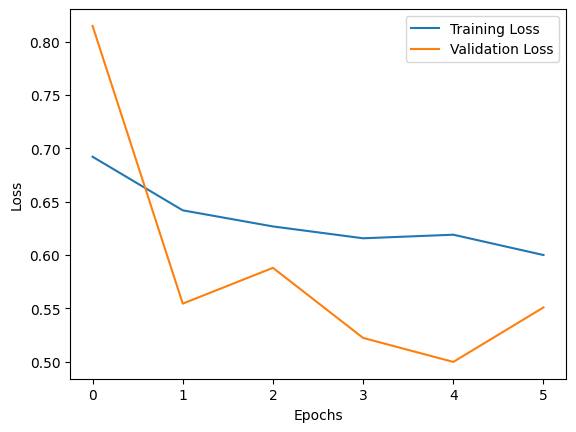

In [ ]:
# Plot the learning curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Find Best hyparameters for the model that perform better
- The ML algorithm got almost same performance and i choosed the Logistic Regression

In [ ]:
# Define the classifier configurations
classifier_configs = [
    {
        'classifier': [LogisticRegression()],
        'classifier__max_iter': [100, 500, 1000],
        'sampler': [None, SMOTE(n_jobs=-1), RandomUnderSampler()],
        'classifier__penalty': ['l1', 'l2'],
    }
]

# Define the model name
model_name = 'Logistic Regression'

# Define the parameter grid for random search
all_configs = [dict(itertools.chain(*(e.items() for e in configuration))) for configuration in
               itertools.product(classifier_configs)]

# Define the pipeline with TfidfVectorizer, sampler, and classifier
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=20000)),
    ('sampler', None),
    ('classifier', LogisticRegression())
])

# Perform random search with cross-validation
rs = RandomizedSearchCV(pipeline,
                        param_distributions=all_configs,
                        n_iter=len(all_configs) * 5,
                        n_jobs=-1,
                        cv=2,
                        scoring={
                            'accuracy': make_scorer(accuracy_score),
                            'f1': make_scorer(f1_score)
                        },
                        refit='f1'
                        )

# Perform cross-validation with scoring
scores = cross_validate(rs, X_train, y_train, scoring=['accuracy', 'f1'], cv=4, return_estimator=True, verbose=3,
                        error_score='raise')

best_estimator = scores['estimator'][0].best_estimator_

print(f"Best Estimator for {model_name}:")
print(best_estimator)

# Fit the best estimator on the training data
best_estimator.fit(X_train, y_train)

# Predict on the test data
y_pred = best_estimator.predict(X_test)

# Calculate precision, recall, and f1 score
report = classification_report(y_test, y_pred)
print(f"\nClassification Report for {model_name}:\n{report}\n")


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
4 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
 

[CV] END ............ accuracy: (test=0.860) f1: (test=0.920) total time=  11.2s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
4 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
 

[CV] END ............ accuracy: (test=0.856) f1: (test=0.918) total time=   5.1s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
2 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
 

[CV] END ............ accuracy: (test=0.860) f1: (test=0.920) total time=   4.4s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
2 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/imblearn/pipeline.py", line 297, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
 

[CV] END ............ accuracy: (test=0.856) f1: (test=0.918) total time=   6.7s
Best Estimator for Logistic Regression:
Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=20000)),
                ('sampler', None),
                ('classifier', LogisticRegression(max_iter=500))])

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.75      0.31      0.44       169
           1       0.88      0.98      0.92       831

    accuracy                           0.87      1000
   macro avg       0.81      0.65      0.68      1000
weighted avg       0.85      0.87      0.84      1000




Best Estimator for Logistic Regression:
Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=20000)),
                ('sampler', None),
                ('classifier', LogisticRegression(max_iter=500))])

# Try on Larger Dataset
- This improved slighly the performance


In [ ]:
# Take the sample of the hole dataset (used all the dataset that remain after the EDA and Preprocessing)
df_sample_2 = df

# Apply preprocessing on the sample dataset
df_sample_2['X'] = df_sample_2['X'].apply(preprocess_text)

#SPLITS

# Split the dataset into X (features) and y (target)
X = df_sample_2['X']
y = df_sample_2['y']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Define the best estimator obtained from the random search
best_estimator = Pipeline([
    ('vectorizer', TfidfVectorizer(max_features=20000)),
    ('sampler', None),
    ('classifier', LogisticRegression(max_iter=500))
])

# Fit the best estimator on the training data
best_estimator.fit(X_train, y_train)



Pipeline(steps=[('vectorizer', TfidfVectorizer(max_features=20000)),
                ('sampler', None),
                ('classifier', LogisticRegression(max_iter=500))])

In [ ]:
# Predict on the test data
y_pred = best_estimator.predict(X_test)

# Calculate precision, recall, and f1 score
report = classification_report(y_test, y_pred)
print(f"\nClassification Report for Logistic Regression :\n{report}\n")


# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC AUC: {roc_auc}")



Classification Report for Logistic Regression :
              precision    recall  f1-score   support

           0       0.77      0.50      0.61      1463
           1       0.90      0.97      0.93      6766

    accuracy                           0.89      8229
   macro avg       0.84      0.74      0.77      8229
weighted avg       0.88      0.89      0.88      8229


ROC AUC: 0.7355757719884858


- Try with different threshold for labels

In [ ]:
# Predict probabilities instead of labels
y_pred_proba = best_estimator.predict_proba(X_test)

# Adjust the threshold for classifying label 0
threshold = 0.3
y_pred_adjusted = [0 if prob[0] > threshold else 1 for prob in y_pred_proba]

# classification report
report_adjusted = classification_report(y_test, y_pred_adjusted)
print(f"\nAdjusted Classification Report for Logistic Regression:\n{report_adjusted}\n")


# accuracy
accuracy = accuracy_score(y_test, y_pred_adjusted)

# F1 score
f1 = f1_score(y_test, y_pred_adjusted)

# precision
precision = precision_score(y_test, y_pred_adjusted)

# recall
recall = recall_score(y_test, y_pred_adjusted)

print('Accuracy:', accuracy)
print('F1 Score:', f1)
print('Precision:', precision)
print('Recall:', recall)



Adjusted Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.65      0.71      0.68      1463
           1       0.94      0.92      0.93      6766

    accuracy                           0.88      8229
   macro avg       0.79      0.81      0.80      8229
weighted avg       0.89      0.88      0.88      8229


Adjusted Accuracy: 0.8799368088467614
Accuracy: 0.8799368088467614
F1 Score: 0.9261805140466228
Precision: 0.9365367180417045
Recall: 0.9160508424475318


In [ ]:
# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_adjusted)
print(f"ROC AUC: {roc_auc}")

# Results:
- Best Model: Logistic Regression (with adjusted threshold)
- Performance on Test Set:

Accuracy: 0.8799368088467614

F1 Score: 0.9261805140466228

Precision: 0.9365367180417045

Recall: 0.9160508424475318

ROC-AUC score:

(results can be improved with more analysis, check result section (in the report))


# Reference
- 1) word cloud for sentiment analysis: https://towardsdatascience.com/text-analytics-101-word-cloud-and-sentiment-analysis-2c3ade81c7e8
- 2) remove emoji function : https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
- 3) How to load and use GloVe word embeddings for LSTM:
  - https://www.youtube.com/watch?v=Qsmn9pL5kcU&list=PLKTZ8NY7JJMae4aipkwKnsQfNwRLePSxY&index=2
  -  https://stackoverflow.com/questions/37793118/load-pretrained-glove-vectors-in-python

- 4) How to use pretrained bert: https://www.kaggle.com/code/pegahpooya/steam-reviews-sentiment-classification#Sentiment-Classification-with-BERT
- 5) find state of art model https://paperswithcode.com/sota/sentiment-analysis-on-imdb

- Others:
  - https://huggingface.co/
  - GloVe embeddings citation: lglove: Jeffrey Pennington, Richard Socher, and Christopher D. Manning. 2014. GloVe: Global Vectors for Word Representation. [pdf] [bib]
  - https://www.kaggle.com/code/pegahpooya/steam-reviews-sentiment-classification#Sentiment-Classification-with-BERT